In [1]:
'''Train MNIST with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import re
import argparse
import numpy as np

import matplotlib.pyplot as plt

In [2]:
directory = "assets/3"
log_path = os.path.join(directory, "log")
checkpoint_path = os.path.join(directory, "ckpt")
data_path = os.path.join(directory, "data")

In [3]:
if not os.path.isdir(directory):
    os.mkdir(directory)
if not os.path.isdir(log_path):
    os.mkdir(log_path)
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)
if not os.path.isdir(data_path):
    os.mkdir(data_path)

In [4]:
class simple_FC(nn.Module):
    def __init__(self, n_hidden):
        super(simple_FC, self).__init__()
        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, n_hidden),
            nn.ReLU()
        )
        self.classifier = nn.Linear(n_hidden, 10)
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [5]:
def train(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        targets = torch.nn.functional.one_hot(targets, num_classes=10).float()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets.argmax(1)).sum().item()
    return 100.*correct/total, train_loss/(batch_idx+1)


def test(epoch, net, model_name, save_checkpoint=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            targets = torch.nn.functional.one_hot(targets, num_classes=10).float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.argmax(1)).sum().item()
    acc = 100.*correct/total
    if save_checkpoint:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, os.path.join(checkpoint_path, '%s.pth'%model_name))
        best_acc = acc
    return 100.*correct/total, test_loss/(batch_idx+1)


In [6]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data: no data augmentation is used
print('==> Preparing data..')
my_transform = transforms.Compose([
    transforms.ToTensor(),
])


trainset = torchvision.datasets.MNIST(
    root=data_path, train=True, download=True, transform=my_transform)
trainset = torch.utils.data.Subset(trainset, indices=np.arange(2000))
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=500, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(
    root=data_path, train=False, download=True, transform=my_transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)

n_hidden_units = [i for i in range(1, 50, 5)]
n_epoch = 6000

for n_hidden_unit in n_hidden_units:
    # Model
    net = simple_FC(n_hidden_unit)
    print('Number of parameters: %d'%sum(p.numel() for p in net.parameters()))
    net = net.cuda()
    net = net.to(device)
    if device == 'cuda':
        net = net.cuda()
        cudnn.benchmark = True
    ### initialization
    if n_hidden_unit == 1: # smallest network
        torch.nn.init.xavier_uniform_(net.features[1].weight, gain=1.0)
        torch.nn.init.xavier_uniform_(net.classifier.weight, gain=1.0)
    elif n_hidden_unit > 25: # interpolation point: Number of data (4000) * number of class (10) = number of parameters (50*784 + 50 + 50*10 + 10)
        torch.nn.init.normal_(net.features[1].weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(net.classifier.weight, mean=0.0, std=0.1)
    else: 
        torch.nn.init.normal_(net.features[1].weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(net.classifier.weight, mean=0.0, std=0.1)
        print('use previous checkpoints to initialize the weights')
        i = 1 # load the closest previous model for weight reuse
        while not os.path.exists(os.path.join(checkpoint_path, 'simple_FC_%d.pth'%(n_hidden_unit-i))):
            print('loading from simple_FC_%d.pth'%(n_hidden_unit-i))
            i += 1
        checkpoint = torch.load(os.path.join(checkpoint_path, 'simple_FC_%d.pth'%(n_hidden_unit-i)))
        with torch.no_grad():
            net.features[1].weight[:n_hidden_unit-i, :].copy_(checkpoint['net']['features.1.weight'])
            net.features[1].bias[:n_hidden_unit-i].copy_(checkpoint['net']['features.1.bias'])
            net.classifier.weight[:, :n_hidden_unit-i].copy_(checkpoint['net']['classifier.weight'])
            net.classifier.bias.copy_(checkpoint['net']['classifier.bias'])
            
    ### training and testing
    best_acc = 0
    start_epoch = 0
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)
    for epoch in range(start_epoch, start_epoch+n_epoch):
        if (epoch+1) % 500 == 0:
            if n_hidden_unit <= 25: # learning rate schedule
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.9
        train_acc, train_loss = train(epoch, net)
        if n_hidden_unit <= 25 and train_acc == 1 or epoch == start_epoch+n_epoch-1: # early stop before interpolation
            test_acc, test_loss = test(epoch, net, 'simple_FC_%d'%(n_hidden_unit), save_checkpoint=True)
            print('classification error reaches 0, stop training')
            break
    print('Training Loss: %.3f | Acc: %.3f%%' % (train_loss, train_acc))
    print('Test Loss: %.3f | Acc: %.3f%%\n' % (test_loss, test_acc))
    with open(os.path.join(log_path, 'FC_%d.txt'%n_hidden_unit), 'w') as fw:
        fw.write('Number of parameters: %d\n'%sum(p.numel() for p in net.parameters()))
        fw.write('Training Loss: %.3f | Acc: %.3f%%\n' % (train_loss, train_acc))
        fw.write('Test Loss: %.3f | Acc: %.3f%%\n' % (test_loss, test_acc))



model_names = sorted([int(fn.split('_')[1].split('.')[0]) for fn in os.listdir(log_path)])

train_losses = {model_name:0. for model_name in model_names}
test_losses = {model_name:0. for model_name in model_names}
train_accs = {model_name:0. for model_name in model_names}
test_accs = {model_name:0. for model_name in model_names}
n_params = {model_name:0. for model_name in model_names}

for model_name in model_names:
    with open(os.path.join(log_path, 'FC_%d.txt'%(model_name))) as f:
        for line in f:
            if line.startswith('Number'):
                n_params[model_name] = float(line.rstrip().split()[-1])
            if line.startswith('Training'):
                loss = re.search(r'Loss: (.*?) \|', line).group(1)
                train_losses[model_name] = float(loss)
                acc = re.search(r'Acc: (.*?)\%', line).group(1)
                train_accs[model_name] = float(acc)
            if line.startswith('Test'):
                loss = re.search(r'Loss: (.*?) \|', line).group(1)
                test_losses[model_name] = float(loss)
                acc = re.search(r'Acc: (.*?)\%', line).group(1)
                test_accs[model_name] = float(acc)



==> Preparing data..


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting assets/3/data/MNIST/raw/train-images-idx3-ubyte.gz to assets/3/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting assets/3/data/MNIST/raw/train-labels-idx1-ubyte.gz to assets/3/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting assets/3/data/MNIST/raw/t10k-images-idx3-ubyte.gz to assets/3/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting assets/3/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to assets/3/data/MNIST/raw

Number of parameters: 805
Saving..
classification error reaches 0, stop training
Training Loss: 0.079 | Acc: 22.050%
Test Loss: 0.080 | Acc: 21.210%

Number of parameters: 4780
use previous checkpoints to initialize the weights
loading from simple_FC_5.pth
loading from simple_FC_4.pth
loading from simple_FC_3.pth
loading from simple_FC_2.pth
Saving..
classification error reaches 0, stop training
Training Loss: 0.036 | Acc: 70.250%
Test Loss: 0.046 | Acc: 64.910%

Number of parameters: 8755
use previous checkpoints to initialize the weights
loading from simple_FC_10.pth
loading from simple_FC_9.pth
loading from simple_FC_8.pth
loading from simple_FC_7.pth
Saving..
classification error reaches 0, stop training
Training Loss: 0.010 | Acc: 97.250%
Test Loss: 0.036 | Acc: 81.060%

Number of parameters: 12730
use previous checkpoints to initialize the weights
loading from simple_FC_15.pth
loading from si

<Figure size 640x480 with 0 Axes>

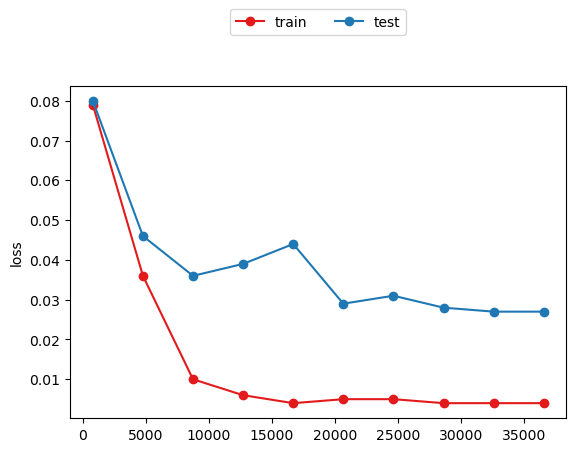

<Figure size 640x480 with 0 Axes>

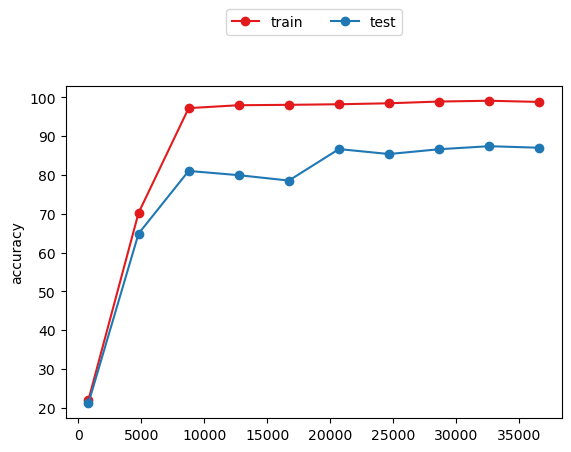

In [7]:
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.plot([n_params[model_name] for model_name in model_names], [train_losses[model_name] for model_name in model_names], marker='o', label='train', color='#e31a1c')
plt.plot([n_params[model_name] for model_name in model_names], [test_losses[model_name] for model_name in model_names], marker='o', label='test', color='#1f78b4')
plt.ylabel('loss')
box = ax.get_position()
plt.tight_layout()
ax.set_position([box.x0, box.y0,
             box.width, box.height * 0.9])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, ncol=4)
plt.show()
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.plot([n_params[model_name] for model_name in model_names], [train_accs[model_name] for model_name in model_names], marker='o', label='train', color='#e31a1c')
plt.plot([n_params[model_name] for model_name in model_names], [test_accs[model_name] for model_name in model_names], marker='o', label='test', color='#1f78b4')
plt.ylabel('accuracy')
box = ax.get_position()
plt.tight_layout()
ax.set_position([box.x0, box.y0,
             box.width, box.height * 0.9])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, ncol=4)
plt.show()